In [1]:
path = "/Users/scarlet/Downloads/Sundial-Private/outputs/"
paper_path = "revision/"
storage = "redis"
selectby = "median"
unit = "ms"

In [2]:
from stylelib import *
from process_helper import *

## 0. Select Color Scheme

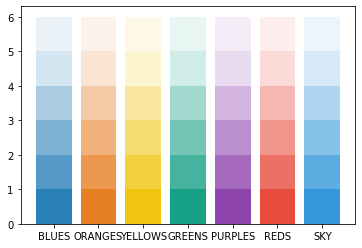

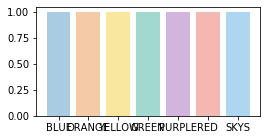

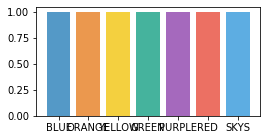

<Figure size 288x144 with 0 Axes>

In [3]:
_, grad_colors = display_colors()
_, bar_colors = select_color_idx(2)
_, line_colors = select_color_idx(4)

In [4]:
C_1PC

'ORANGE'

In [5]:
C_2PC

'BLUE'

In [9]:
plt.rcParams.update({'font.size': 18})
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

## 1. ELR - Contention

In [7]:
def process_throughput(x, df):
    if not isinstance(x, str):
        agg_throughput = df.groupby(['COMMIT_ALG', 'i'] + x, as_index=False)['Throughput'].sum()
    else:
        # sum up throughput for each trial
        agg_throughput = df.groupby(['COMMIT_ALG', 'i', x], as_index=False)['Throughput'].sum()
    return agg_throughput

def process_latency(x, df, latency_type="dist_latency", select=None):
    # require agg_throughput to indicate trial id as trials are selected by max throughput
    # process the latency
    latency = []

    if select is not None:
        if not isinstance(x, str):
            select = select.set_index(["COMMIT_ALG"] + x)
        else:
            select = select.set_index(["COMMIT_ALG", x])
            
    if isinstance(x, str):
        for (alg, i, v), group in df.groupby(['COMMIT_ALG', 'i', x]):
            if select is not None:
                if select.loc[(alg, v), "i"] != i:
                    continue
            # calculate weighted sum for each column/attribute
            weight = WEIGHT[latency_type]
            record = {"COMMIT_ALG": alg, "i": i, x: v}
            for y in TYPE[latency_type]:
                if group[weight].sum() == 0:
                    print("[WARNING]: zero weight %s" % weight)
                    agg = np.nan
                    break
                agg = (group[y] * group[weight]).sum() / group[weight].sum()
                record[PREFIX+y] = agg
            if np.isnan(agg):
                continue
            latency.append(record)
    else:
        for tags, group in df.groupby(['COMMIT_ALG', 'i'] + x):
            alg = tags[0]
            i = tags[1]
            v = tags[2:]
            if select is not None:
                if select.loc[tuple([alg]+list(v)), "i"] != i:
                    continue
            # calculate weighted sum for each column/attribute
            weight = WEIGHT[latency_type]
            record = {"COMMIT_ALG": alg, "i": i}
            for kid, key in enumerate(x):
                record[key] = v[kid]
            for y in TYPE[latency_type]:
                if group[weight].sum() == 0:
                    print("[WARNING]: zero weight %s" % weight)
                    agg = np.nan
                    break
                agg = (group[y] * group[weight]).sum() / group[weight].sum()
                record[PREFIX+y] = agg
            if np.isnan(agg):
                continue
            latency.append(record)
    latency = pd.DataFrame(data=latency)
    return latency


def aggregate(x, df, latency_type="dist_latency", agg="latency", how="minmax"):
    # drop invalid data
    data = df.dropna(subset=y_agg_latency+["Throughput"], axis=0)
    data = data[data['Throughput'] != 0]
    throughput = process_throughput(x, data)
    latency = process_latency(x, data, latency_type=latency_type)
    if isinstance(x, str):
        select_cols = ['COMMIT_ALG', 'i', x]
        select_cols_noid = ['COMMIT_ALG', x]
    else:
        select_cols = ['COMMIT_ALG', 'i'] + x
        select_cols_noid = ['COMMIT_ALG'] + x
        
    if agg != "throughput":
        if how == "minmax":
            idx_max = latency.groupby(select_cols_noid)[PREFIX+TYPE[latency_type][0]].idxmin().values
            print("selected trial with min {}".format(PREFIX+TYPE[latency_type][0]))
        elif how == "median":
            agg_col = PREFIX+TYPE[latency_type][0]
            idx_max = []
            for name, group in latency.groupby(select_cols_noid):
                n = int(group.shape[0] / 2) - 1
                idx_max.append(group.sort_values(agg_col).index.values[n])
            print("selected trial with median {}".format(PREFIX+TYPE[latency_type][0]))
        agg_latency = latency.loc[idx_max]
        agg_throughput = throughput.loc[select(throughput, agg_latency, select_cols)]
    else:
        # select the trials with highest throughput
        idx_max = agg_throughput.groupby(select_cols_noid)['Throughput'].idxmax().values
        agg_throughput = agg_throughput.loc[idx_max]
        print("selected trial with max throughput")
        agg_latency = latency.loc[select(latency, agg_throughput, select_cols)]
    return agg_throughput, agg_latency

### 1.1 YCSB - Zipfian

In [10]:
exp = "%s_zipf_elr_redis"%storage
x = "ZIPF_THETA"
opt = "EARLY_LOCK_RELEASE"
opt_label = "ELR"
df = pd.read_csv(path+"zipf_{}_elr.csv".format(storage))
df = apply_mask(df, [("ZIPF_THETA", ["ne", 0.3])])
# agg: "latency" or "Throughput"
agg_throughput, agg_latency = aggregate([x, opt], df, latency_type="dist_latency", agg="latency", how=selectby)

selected trial with median AGG_average_dist_latency


In [11]:
agg_multi_latency = process_latency([x, opt], df, latency_type="multi_part_latency", select=agg_latency)

### 2) Latency

In [12]:
def plot_opt_latency(x, opt, opt_label, data, ys=y_agg_latency, fig=None, ax=None, xlabel="", prefix=PREFIX, ylim=1.5, 
                 line_colors=BLUES, width=5, unit="ms", ylim_speedup=1.5, 
                 plot_speedup=False, speedup_yspace=5, speedup_xspace=-1):
    linestyle = ["-", "--"] # avg, tail
    if fig is None:
        fig, ax = plt.subplots()
    marker = ["^", "o"] # 1pc, 2pc
    color = [line_colors[C_1PC], line_colors[C_2PC]]
    alglabel = ["Cornus", "2PC"]
    scale = 1
    if unit == "ms":
        scale = 1000
    elif unit == "us":
        scale = 1000000    
    ymax = 0
    labels = []
    for i, alg in enumerate(["TWO_PC", "ONE_PC"]):
        if alg == "ONE_PC":
            alg_label = "Cornus"
        else:
            alg_label = "2PC"
        tmp = data[data['COMMIT_ALG'] == alg]
        for k, switch in enumerate([False, True]):
            if switch:
                switch_label = "-{}".format(opt_label)
            else:
                switch_label = ""
            y_data = tmp[tmp[opt] == switch].sort_values(by=x)
            for j, y in enumerate(ys):
                if "average" in y:
                    metric_label = " avg"
                else:
                    metric_label = " 99%"
                # default unit is second
                y_data[prefix+y] = y_data[prefix+y] * scale
                ymax = max(y_data[prefix+y].max(), ymax)
                ax.plot(x, prefix+y, marker=marker[i], data=y_data, linestyle=linestyle[k], 
                        label=alglabel[i] + " "+ y.replace('_',' '), color=color[i])
                labels.append(alg_label + switch_label + metric_label)
    ax.legend(labels,
              loc='upper left', ncol=1, labelspacing=0.1, prop={'size': 14},
              columnspacing=0, handletextpad=0.1, frameon=False, bbox_to_anchor=(-0.01,1.05))
    ax.set_ylim([0, ymax*ylim])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Txn Latency ({})".format(unit))
    plt.grid(axis='y', linestyle='--', linewidth=0.35)
    fig.set_size_inches(5, 2.8)
    if plot_speedup:
        twopc = apply_mask(data, [("COMMIT_ALG", "TWO_PC"), (opt, True)])[prefix+ys[0]].values * scale
        twopc_nonopt = apply_mask(data, [("COMMIT_ALG", "TWO_PC"), (opt, False)])[prefix+ys[0]].values * scale
        onepc = apply_mask(data, [("COMMIT_ALG", "ONE_PC"), (opt, True)])[prefix+ys[0]].values * scale
        onepc_nonopt = apply_mask(data, [("COMMIT_ALG", "ONE_PC"), (opt, False)])[prefix+ys[0]].values * scale
        
        speedup = twopc_nonopt / onepc_nonopt
        nominator = twopc_nonopt
        x_data = data[x].unique()
        for xv, yv, s in zip(x_data, nominator, speedup):
            ax.text(xv + speedup_xspace, yv + speedup_yspace + 0.1 * ymax, "%.1fx"%(s), fontsize=12)
        print("speedup: {}".format(speedup))
        
        speedup = twopc / onepc
        nominator = twopc
        x_data = data[x].unique()
        for xv, yv, s in zip(x_data, nominator, speedup):
            ax.text(xv + speedup_xspace, yv + speedup_yspace, "%.1fx"%(s), fontsize=12, color="red")
        print("speedup: {}".format(speedup))
        return fig, ax, None
    return fig, ax

speedup: [1.08532391 1.12278426 1.36269273 1.20113609]
speedup: [1.06836376 1.12482783 1.11274567 1.22934122]


Text(0, 375.0, 'speedup cornus over 2pc')

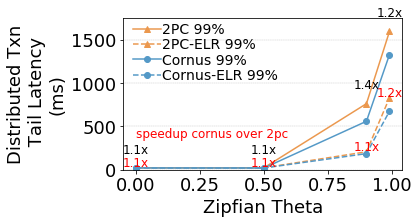

In [40]:
x = "ZIPF_THETA"
opt = "EARLY_LOCK_RELEASE"
opt_label = "ELR"

data = agg_latency.sort_values(by=x)
fig, ax, ax2 = plot_opt_latency(x, opt, opt_label, data, ys=[y_agg_dist_latency[1]], 
                            xlabel="Zipfian Theta",
                            plot_speedup=True, speedup_yspace=10, speedup_xspace=-0.05,
                            line_colors=line_colors, ylim=1.1, unit="ms")
ax.set_ylabel("Distributed Txn\n Tail Latency\n(%s)"%unit)
ax.text(0, 0.5*750, "speedup cornus over 2pc", fontsize=12, color="red")
#plt.savefig(paper_path+exp+"_latency_({}_latency).pdf".format(selectby), bbox_inches="tight")

speedup: [1.09509291 1.09532674 1.18935164 1.24163002]
speedup: [1.06817685 1.09767505 1.11200349 1.26133134]


Text(0, 33.6, 'speedup cornus over 2pc')

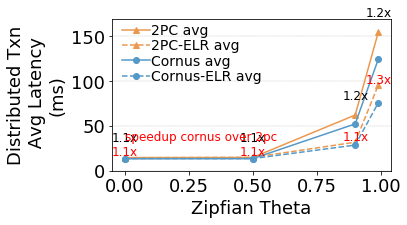

In [39]:
x = "ZIPF_THETA"
opt = "EARLY_LOCK_RELEASE"
opt_label = "ELR"

data = agg_latency.sort_values(by=x)
fig, ax, ax2 = plot_opt_latency(x, opt, opt_label, data, ys=[y_agg_dist_latency[0]], 
                            xlabel="Zipfian Theta",
                            plot_speedup=True, speedup_yspace=2, speedup_xspace=-0.05,
                            line_colors=line_colors, ylim=1.1, unit="ms")
ax.set_ylabel("Distributed Txn\n Avg Latency\n(%s)"%unit)
ax.text(0, 0.48*70, "speedup cornus over 2pc", fontsize=12, color="red")
#plt.savefig(paper_path+exp+"_latency_({}_latency).pdf".format(selectby), bbox_inches="tight")

### 3) breakdown

In [65]:
def plot_opt_breakdown(x, opt, opt_label, zipper1, zipper2, xcate1, xcate2, bar_colors, 
                       grad_colors, how="max", agg_multi_latency=None, ax=None, fig=None,
                   extra_legend=True, unit="ms", ylim=1.5):
    fig, (ax, ax2) = plt.subplots(1,2)
    color_names = [C_1PC, "YELLOW", C_2PC, "PURPLE"]
    color_patches = [bar_colors[c] for c in color_names]
    color = [grad_colors[c+"S"] for c in color_names]
    pattern = ALL_PATTERNS
    # width = 0.2
    offset = [-0.3, -0.1, 0.1, 0.3]
    cases = []
    for alg in ["ONE_PC", "TWO_PC"]:
        for switch in [False, True]:
            cases.append((alg, switch))
    ymax=0
    for idx, (d, ys) in enumerate(zipper1):
        data = apply_mask(agg_multi_latency, [(x, d)])
        for j, case in enumerate(cases):
            bottom = 0
            plot_data = apply_mask(data, [("COMMIT_ALG", case[0]), (opt, case[1])])
            for i, y in enumerate(ys):
                v = plot_data[PREFIX+y].values
                if unit == "ms":
                    v = v / 1000
                elif unit == "s":
                    v = v / 1000000
                p = ax.bar(idx+offset[j], v, bottom=bottom, width=0.18, 
                           color=color[j][i], hatch=pattern[i], edgecolor='black')
                bottom += v
            ymax = max(ymax, bottom.max())
    ax.set_xticklabels([""]+xcate1)
    ax.set_ylim((0, 30))
    for idx, (d, ys) in enumerate(zipper2):
        data = apply_mask(agg_multi_latency, [(x, d)])
        for j, case in enumerate(cases):
            bottom = 0
            plot_data = apply_mask(data, [("COMMIT_ALG", case[0]), (opt, case[1])])
            for i, y in enumerate(ys):
                v = plot_data[PREFIX+y].values
                if unit == "ms":
                    v = v / 1000
                elif unit == "s":
                    v = v / 1000000
                p = ax2.bar(idx+offset[j], v, bottom=bottom, width=0.18, 
                           color=color[j][i], hatch=pattern[i], edgecolor='black')
                bottom += v
            ymax = max(ymax, bottom.max())
    ax2.set_xticklabels([""]+xcate2)
    ax2.set_ylim((0, 180))
    plt.grid(axis='y', linestyle='--', linewidth=0.35)
    if extra_legend:
        handles = get_color_patches([""]*len(color_names), color_patches)
        legend_l = ["Cornus","Cornus-ELR", "2PC", "2PC-ELR"]
        legend2 = plt.legend([handles[hid] for hid in [0,2,1,3]], 
                             [legend_l[hid] for hid in [0,2,1,3]], 
                             loc="upper left", bbox_to_anchor=((-1.5,1.45)), ncol=2, frameon=False,
                             prop={'size': 18}, columnspacing=0.3, handletextpad=0.2)
        plt.gca().add_artist(legend2)
    labels = ["execution", "prepare", "commit", "abort"]
    ax.legend(get_pattern_patches(labels, pattern), labels,prop={'size': 16}, 
              loc='upper left', ncol=1, labelspacing=0.1, bbox_to_anchor=((-0.08,1.08)),
              columnspacing=0, handletextpad=0.5, frameon=False)
    plt.xlabel("Zipfian Theta")
    ax.set_ylabel("Latency Breakdown \n(%s)"%unit)
    fig.set_size_inches(6, 3)
    plt.subplots_adjust(wspace=0.3)
    return fig, ax

In [43]:
agg_multi_latency.groupby(["ZIPF_THETA", "COMMIT_ALG", "EARLY_LOCK_RELEASE"])["total"].min()

ZIPF_THETA  COMMIT_ALG  EARLY_LOCK_RELEASE
0.00        ONE_PC      False                  13393.639286
                        True                   13687.274894
            TWO_PC      False                  14667.322256
                        True                   14620.418029
0.50        ONE_PC      False                  13552.401661
                        True                   13629.632506
            TWO_PC      False                  14844.289739
                        True                   14960.873395
0.90        ONE_PC      False                  52293.657507
                        True                   28682.963516
            TWO_PC      False                  62195.582611
                        True                   31895.563563
0.99        ONE_PC      False                 124297.472064
                        True                   75660.879711
            TWO_PC      False                 154331.073088
                        True                   95433.4811

In [44]:
124297.472064/75660.879711

1.6428235111563068

In [45]:
154331.073088/95433.481174

1.6171585819720273

In [46]:
154331.073088 /124297.472064 

1.241626804835869

In [47]:
95433.481174 / 75660.879711

1.2613319001645886

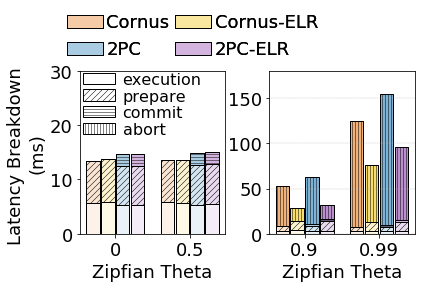

In [66]:
xcate1 = [0, 0.5]
zipper1 = zip(xcate1, [y_multi_part_latency]*len(xcate1))
xcate2 = [0.9, 0.99]
zipper2 = zip(xcate2, [y_multi_part_latency]*len(xcate2))
fig, ax = plot_opt_breakdown(x, opt, opt_label, zipper1, zipper2, xcate1, xcate2, bar_colors, grad_colors, 
                             how=None, agg_multi_latency=agg_multi_latency, ylim=1.1)
ax.set_xlabel("Zipfian Theta")
plt.savefig(paper_path+exp+"_latency({}).pdf".format(selectby), bbox_inches="tight")

In [126]:
def plot_opt_throughput(x, opt, opt_label, zipper, xcategories, bar_colors, grad_colors, 
                        how="max", agg_data=None, ax=None, fig=None,
                        extra_legend=True, unit="ms", ylim=1.5):
    if ax is None:
        fig, ax = plt.subplots()
    color_names = [C_1PC, "YELLOW", C_2PC, "PURPLE"]
    color_patches = [bar_colors[c] for c in color_names]
    pattern = ALL_PATTERNS
    # width = 0.2
    offset = [-0.3, -0.1, 0.1, 0.3]
    cases = []
    for alg in ["ONE_PC", "TWO_PC"]:
        for switch in [False, True]:
            cases.append((alg, switch))
    ymax=0
    for idx, (d, y) in enumerate(zipper):
        data = apply_mask(agg_data, [(x, d)])
        for j, case in enumerate(cases):
            plot_data = apply_mask(data, [("COMMIT_ALG", case[0]), (opt, case[1])])
            v = plot_data[y].values
            p = ax.bar(idx+offset[j], v, width=0.18, 
                       color=color_patches[j], hatch=pattern[j], edgecolor='black')
            ymax = max(ymax, v)

    plt.grid(axis='y', linestyle='--', linewidth=0.35)
    labels = ["Cornus","Cornus-ELR", "2PC", "2PC-ELR"]
    ax.legend(labels,loc="upper left", bbox_to_anchor=((0.48,1.06)), ncol=1, frameon=False,
                             prop={'size': 18}, columnspacing=0.3, handletextpad=0.2)
    ax.set_xlabel("Txn Type")
    ax.set_ylabel("Throughput (txns/s)")
    plt.ylim(0, 1800)
    plt.xticks(np.arange(0, len(xcategories)*0.5, 0.5), xcategories)
    fig.set_size_inches(5.5, 4)
    return fig, ax

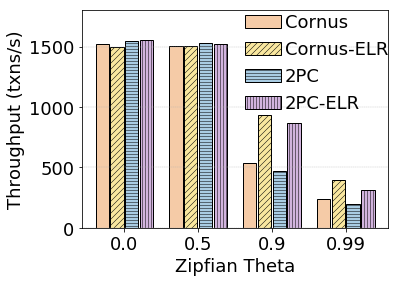

In [127]:
xcate = data[x].unique()
zipper = zip(xcate, ["Throughput"]*len(xcate))
fig, ax = plot_opt_throughput(x, opt, opt_label, zipper, xcate, bar_colors, grad_colors, 
                             how=None, agg_data=agg_throughput, ylim=1.1)
plt.xticks(np.array([0, 1, 2, 3]), xcate)
#ax.set_yscale('log')
ax.set_xlabel("Zipfian Theta")
plt.savefig(paper_path+exp+"_throughput({}).pdf".format(selectby), bbox_inches="tight")